# Exemplar visualization of results from optical spectroscopy (here ellipsometry)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import json
import shutil

### Get a dataset

Spectrum of Si wafer with 2nm SiO2.

In [2]:
shutil.unpack_archive('190801_Si_SiO2_2nm_test.zip')
! ls

190801_Si_SiO2_2nm_test.dat		190801_Si_SiO2_2nm_test.zip
190801_Si_SiO2_2nm_test_mat_fehler.txt	README.txt
190801_Si_SiO2_2nm_test_mat.txt		VisualizeOPTCSData.01.ipynb
190801_Si_SiO2_2nm_test.SE


### Parsing from file formats

Chris Sturm explained that the dataset was collected with a JaWoollam instrument via CompleteEASE software https://www.jawoollam.com/ellipsometry-software/completeease
To the best of his knowledge there is not yet an open-source parser for translating the proprietary *.SE file format that CompleteEASE creates into an open format.
So Chris used another proprietary software, WVase https://www.jawoollam.com/ellipsometry-software/wvase, to transcode the *.SE into *.dat, which is a set of ASCII tables with metadata.
From this *.dat he uses a custom parser to extract results into a format with which it is easier for him to work with to discuss the experiment. This format is an ASCII table where the individual spectra are stack as blocks of table glued together. This format he refers to as *_mat.txt and *_mat_fehler.txt specifically where the second format gives the uncertainties. This is what we work with in this example.

In [5]:
MYDATASET = '190801_Si_SiO2_2nm_test'

In [6]:
import pandas as pd
data = pd.read_csv(MYDATASET+'_mat.txt', delimiter='\s+')

### Data wrangling and cleaning

Two relevant observations wrt to formatting:
* The column names in the header section get parsed incorrectly because the strings themselves contain space delimiters.
* Some columns do not contain relevant measured data but dummy data instead these are according to Chris:
* Drehwinkel/ x Position
* y-Position
* lf. Proben Nummber
* SE Type
* and all mm<i,j> columns

The original header line was:
Energie	Einfallswinkel	Drehwinkel/ x Position y-Position	lf. Proben Nummer	SE-Type	Psi	Delta	mm11	mm12	mm13	mm14	mm21	mm22	mm23	mm24	mm31	mm32	mm33	mm34	mm41	mm42	mm43	mm44
All we are interested for now is the 

In [7]:
#data['mm34'] = data['mm34'].replace(0.0, np.nan)
data = data.drop('Drehwinkel/', 1)
data = data.drop('x', 1)
data = data.drop('Position', 1)
data = data.drop('y-Position', 1)
for i in [1,2,3,4]:
    for j in [1,2,3,4]:
        columnname = 'mm'+str(i)+str(j)
        data = data.drop(columnname, 1)
data = data.drop('Nummer', 1)
data = data.drop('SE-Type', 1)
data = data.drop('Psi', 1)
data = data.drop('Delta', 1)
#finally, reflecting the above-mentioned comments we need to relabel column lf. with Psi and Proben with Delta
data = data.rename(columns={"lf.": "Psi (degree)", "Proben": "Delta (degree)"})

In [8]:
data

,Energie,Einfallswinkel,Psi (degree),Delta (degree)
0,1930.0,50.0,40.010899,140.596375
1,1940.0,50.0,40.070530,140.679840
2,1950.0,50.0,40.052708,140.847351
3,1960.0,50.0,40.038048,141.239487
4,1970.0,50.0,40.086514,141.575409
...,...,...,...,...
4347,16900.0,65.0,14.899776,178.085114
4348,16925.0,65.0,14.861681,178.171539
4349,16950.0,65.0,14.917637,178.184357
4350,16975.0,65.0,14.960825,178.107681


It remains to split the tables again into the different spectra for different "Einfallswinkel", i.e. angle of incidence.

In [10]:
incidence_angles = np.unique(data['Einfallswinkel'].to_numpy())
print(incidence_angles)

[50. 55. 60. 65.]


### Now, visualizing the "spectra".

Text(0, 0.5, 'Psi (degree)')

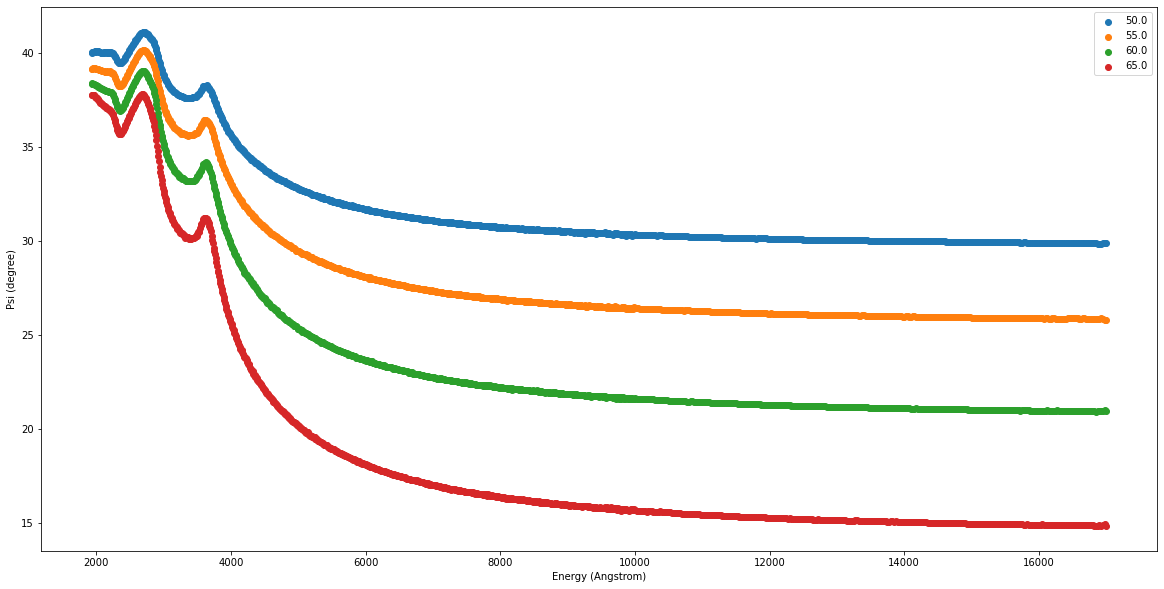

In [11]:
fig, ax1 = plt.subplots( figsize=[20, 10] )
for i in incidence_angles:
    #i = 50.
    energy = data[np.abs(data['Einfallswinkel'] - i) < (np.finfo(np.float32).eps*10)]['Energie']
    psi = data[np.abs(data['Einfallswinkel'] - i) < (np.finfo(np.float32).eps*10)]['Psi (degree)']
    #delta = data[np.abs(data['Einfallswinkel'] - i) < (np.finfo(np.float32).eps*10)]['Delta (degree)']
    plt.scatter( energy, psi )
    #plt.scatter( energy, delta )    
plt.legend(incidence_angles)
plt.xlabel(r'Energy (Angstrom)') #Chris explained they call the respective equivalent wavelength an energy in their domain
plt.ylabel(r'Psi (degree)')
#plt.ylabel(r'Delta (degree)')

### Next steps

* Define and use a NeXus application definition for optical spectroscopy
* Develop parser for proprietary formats
* Reorganize/rewrite plotting functions
* Use widgets (e.g. bokeh or ipywidgets) to make figure interactive
* Use widgets to make spectra selectable
* Make spectrum ranges clickable/selectable to define
* Interface with auto-indexing tool